# Theoretical velocity profile

In [82]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sci

SEED = 12345

In [83]:
def get_n_interpolation(power_law: str = "classical") -> sci.interpolate.BSpline:
    """
    Generate a B-spline interpolation function for power law coefficient (n).

    Args:
        power_law (str): The power law to use for interpolation ('classical' or 'salama').

    Returns:
        sci.interpolate.BSpline: B-spline interpolation function for n.
    """
    # Initialize Re and n values based on the selected power law
    if power_law == "classical":
        Re_l = np.linspace(100, 2000, 20)
        n_l = Re_l * 0 + 1.77
        Re_r = np.linspace(10000, 20000, 20)
        n_r = 2.021 * Re_r**0.1077
    elif power_law == "salama":
        Re_l = np.linspace(100, 2000, 20)
        n_l = Re_l * 0 + 1.0
        Re_r = np.linspace(10000, 20000, 20)
        n_r = 0.77 * np.log(Re_r) - 3.47

    # Interpolate the data using B-spline
    tck = sci.interpolate.splrep(
        np.concatenate([Re_l, Re_r]), np.concatenate([n_l, n_r]), k=2, s=0
    )
    return sci.interpolate.BSpline(*tck)


# Get B-spline interpolations
iterp_c = get_n_interpolation(power_law="classical")
iterp_s = get_n_interpolation(power_law="salama")


def get_vel_profile(
    Re: float,
    mu: float,
    rho: float,
    L: float,
    R: float,
    Nr: int,
    power_law: str = "salama",
) -> (np.ndarray, np.ndarray):
    """
    Calculate the velocity profile in a duct.

    Args:
        Re (float): Reynolds number.
        mu (float): Viscosity of the fluid [Pas].
        rho (float): Density of the fluid [kg/m^3].
        L (float): Length of the duct [m].
        R (float): Radius of the duct [m].
        Nr (int): Number of radial points for the profile.
        power_law (str): The power law to use for velocity profile calculation ('classical' or 'salama').

    Returns:
        np.ndarray: Array of radial coordinates [m].
        np.ndarray: Array of velocities at radial positions [m/s].

    If Re is within the laminar range (Re <= 2000), it computes the velocity profile using
    Hagen-Poiseuille equation.
    If Re is in the transitional range (2000 < Re <= 10000), it returns interpolation law (be aware of it).
    If Re is in the turbulent range (10000 < Re <= 10000000), it calculates the velocity
    profile using a power-law model.
    """
    Ks = 2.2e9  # Bulk modulus of water [Pa]
    r = np.linspace(0, R, Nr)
    velx_avg = Re * mu / (rho * 2 * R)  # average velocity [m/s]
    Ma = velx_avg / np.sqrt(Ks / 1000)

    if Re <= 2000 and Ma < 0.8:  # Laminar (Hagen-Poiseuille)
        deltap = -8 * mu * velx_avg * L / (R**2)
        velx_y = 1 / 4 * deltap / (mu * L) * (r**2 - R**2)

    elif 2000 < Re <= 10000 and Ma < 0.8:  # Transitional region (interpolation)
        if power_law == "classical":
            n = iterp_c(Re)  # For Re between 1e4 and 1e6
            velx_max = velx_avg / (2 * n**2 / ((n + 1) * (2 * n + 1)))
            velx_y = velx_max * (1 - r / R) ** (1 / n)  # Power-law velocity profile
        elif power_law == "salama":
            n = iterp_s(Re)
            m = 2.0
            velx_max = velx_avg / (2 * sci.special.beta(2 / m, (n + 1) / n) / m)
            velx_y = velx_max * (1 - (r / R) ** m) ** (1 / n)

    elif 10000 < Re <= 10000000 and Ma < 0.8:  # Turbulent (Power law)
        if power_law == "classical":
            n = 2.021 * Re**0.1077  # For Re between 1e4 and 1e6
            velx_max = velx_avg / (2 * n**2 / ((n + 1) * (2 * n + 1)))
            velx_y = velx_max * (1 - r / R) ** (1 / n)  # Power-law velocity profile
        elif power_law == "salama":
            n = 0.77 * np.log(Re) - 3.47
            m = 2.0
            velx_max = velx_avg / (2 * sci.special.beta(2 / m, (n + 1) / n) / m)
            velx_y = velx_max * (1 - (r / R) ** m) ** (1 / n)
    else:
        velx_y = None
    return r, velx_y

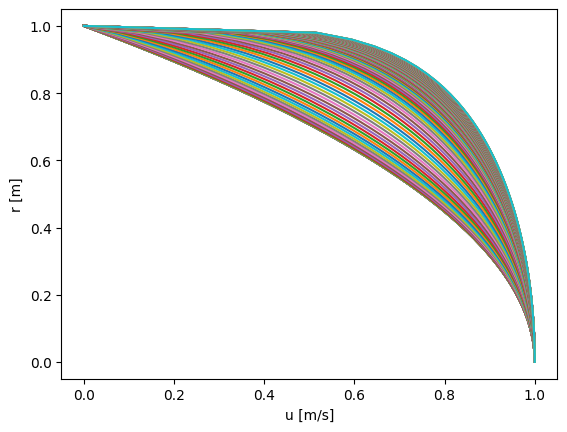

In [84]:
mu = 1e-3
rho = 1e3
L = 10
R = 0.1
Nr = 50
for Re in np.concatenate(
    [np.linspace(10, 2e3, 20), np.linspace(2e3, 1e4, 50), np.linspace(1e4, 5e4, 100)]
):
    r, velx_y = get_vel_profile(Re, mu, rho, L, R, Nr, power_law="salama")
    plt.plot(velx_y / velx_y[0], r / r.max())
    # plt.plot(velx_y, r)
plt.xlabel("u [m/s]")
plt.ylabel("r [m]")
plt.show()

In [85]:
N_profiles = 100000  # 100000
Nr = 50
rand_gen = np.random.default_rng(seed=SEED)

Re_all = np.zeros((N_profiles, 1))
space_all = np.zeros((N_profiles, Nr))
data_all = np.zeros((N_profiles, Nr + 4))

i = 0
while i < N_profiles:
    # sampling
    rand_numb = rand_gen.random()
    if rand_numb < 0.15:
        # laminar
        Re = rand_gen.uniform(0.1, 2e3)  # Reynolds number [-] in interval (.1, 2e3)
    elif rand_numb < 0.25:
        # transitional (first half)
        Re = rand_gen.uniform(2e3, 5e3)  # Reynolds number [-] in interval (2e3, 1e6)
    elif rand_numb < 0.3:
        # transitional (second half)
        Re = rand_gen.uniform(5e3, 1e4)  # Reynolds number [-] in interval (1.0, 1e4)
    else:
        # turbulent
        Re = rand_gen.uniform(1e4, 1e6)  # Reynolds number [-] in interval (1e4, 1e6)
    R = rand_gen.uniform(0.05, 0.5)  # Radius of the duct [m] in interval (0.1, .5)
    L = rand_gen.uniform(5.0, 100.0)  # Length of the duct [m] in interval (5.0, 100.0)
    rho = np.abs(
        rand_gen.normal(loc=1000.0, scale=50.0)
    )  # Density of the liquid [kg/m^3] in interval (.0, +inf)
    mu = np.abs(
        rand_gen.normal(loc=1e-3, scale=5e-4)
    )  # Viscosity of the liquid [Pas] in interval (.0, +inf)
    # print(Re, mu, rho, L, R)
    r, velx_y = get_vel_profile(Re, mu, rho, L, R, Nr, power_law="salama")
    if velx_y is None:
        # print("Skip Re:", Re)
        continue
    # store
    Re_all[i, :] = Re
    space_all[i, :] = r
    data_all[i, :] = np.concatenate((np.array([mu, rho, L, R]), velx_y))
    # plt.plot(velx_y/velx_y[0], r/r.max())
    # plt.xlabel('u [m/s]')
    # plt.ylabel('r [m]')
    i += 1

In [86]:
velx_y.shape

(50,)

Save on file

In [87]:
np.savetxt(
    "velprof-data.csv",
    data_all,
    delimiter=",",
    fmt="%12.8e",
    header=",".join(["mu(Pas)", "rho(kg/m3)", "L(m)", "R(m)"])
    + ","
    + ",".join([f"vel[{i}](m/s)" for i in range(Nr)]),
    comments="",
)
np.savetxt(
    "velprof-space.csv",
    space_all,
    delimiter=",",
    fmt="%12.8e",
    header=",".join([f"r[{i}](m)" for i in range(Nr)]),
    comments="",
)
np.savetxt(
    "velprof-Re.csv", Re_all, delimiter=",", fmt="%12.8e", header="Re(-)", comments=""
)

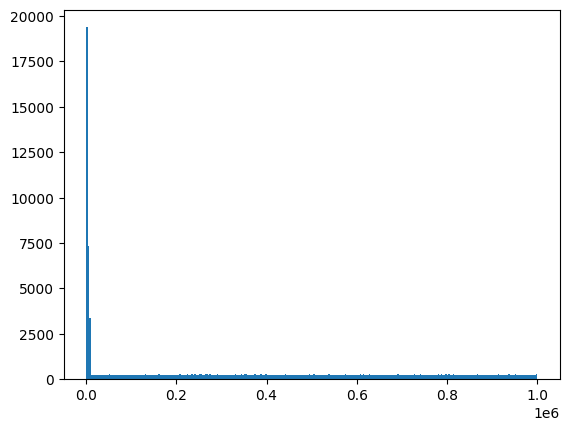

In [88]:
plt.hist(Re_all, bins=300)
plt.show()